In [2]:
# Import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn

In [3]:
# Import dataset
path_training = "Training and Testing Sets/UNSW_NB15_training-set.csv"
path_testing = "Training and Testing Sets/UNSW_NB15_testing-set.csv"
df_train = pd.read_csv(path_training)
df_test = pd.read_csv(path_testing)

# Convert categorical features to float
categorical_features = ['proto', 'service', 'state', 'attack_cat']
for feature in categorical_features:
    df_train[feature] = df_train[feature].astype('category').cat.codes
    df_test[feature] = df_test[feature].astype('category').cat.codes

from sklearn.preprocessing import MinMaxScaler

# Directement MinMaxScaler en [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))

df_train_scaled = pd.DataFrame(
    scaler.fit_transform(df_train.drop(columns=['label'])), 
    columns=df_train.columns.drop('label')
)
df_train_scaled['label'] = df_train['label'].values

df_test_scaled = pd.DataFrame(
    scaler.transform(df_test.drop(columns=['label'])), 
    columns=df_test.columns.drop('label')
)
df_test_scaled['label'] = df_test['label'].values

In [4]:
# Determine important features
# Based on correlation with the label, we can select features with high absolute correlation values
df_train = df_train.drop("attack_cat",axis=1)
df_test = df_test.drop("attack_cat",axis=1)
corr_matrix = df_train.corr()
important_features = corr_matrix['label'].abs().sort_values(ascending=False)
print("Important features based on correlation with label:\n", important_features)

# Select top N features (excluding the label itself)
N = 20
top_features = important_features.index[1:N+1].tolist()
print("Top {} features selected for training:\n".format(N), top_features)

# Prepare data for training
X_train = df_train[top_features]
y_train = df_train['label']
X_test = df_test[top_features]
y_test = df_test['label']
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("X_train after scaling shape:", X_train.shape)
print("X_test after scaling shape:", X_test.shape)

Important features based on correlation with label:
 label                1.000000
id                   0.727173
sttl                 0.692741
ct_state_ttl         0.577704
state                0.497685
dload                0.393739
ct_dst_sport_ltm     0.357213
dmean                0.341806
rate                 0.337979
swin                 0.333633
dwin                 0.319626
ct_src_dport_ltm     0.305579
ct_dst_src_ltm       0.303855
stcpb                0.255006
dtcpb                0.250340
ct_src_ltm           0.238225
ct_dst_ltm           0.229887
ct_srv_src           0.229044
ct_srv_dst           0.228046
is_sm_ips_ports      0.184679
sload                0.182870
sinpkt               0.176110
dpkts                0.118591
ackdat               0.097364
dttl                 0.095049
dloss                0.094685
tcprtt               0.081584
dbytes               0.076871
djit                 0.060870
synack               0.058299
spkts                0.052178
dur              

# Simple Neural Network

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Simple feedforward neural network
clf = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    random_state=42,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    verbose=False
)

# Train
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

Test accuracy: 0.5135

Classification report:
              precision    recall  f1-score   support

           0     0.4694    0.6326    0.5389     37000
           1     0.5813    0.4164    0.4852     45332

    accuracy                         0.5135     82332
   macro avg     0.5254    0.5245    0.5121     82332
weighted avg     0.5310    0.5135    0.5093     82332



In [6]:
import glob

# Load synthetic data and compare classifier performance

synth_dir = r"C:\Users\phasi\Documents\GitHub\Final-Project-GAN-Cybersecurity\synthetic_saves"

# find a plausible synthetic file (csv, pkl, npy)
candidates = glob.glob(os.path.join(synth_dir, "*.csv")) + \
             glob.glob(os.path.join(synth_dir, "*.pkl")) + \
             glob.glob(os.path.join(synth_dir, "*.npy"))
if not candidates:
    raise FileNotFoundError(f"No synthetic files found in {synth_dir}. Expected .csv/.pkl/.npy")

synth_path = candidates[0]
print("Loading synthetic file:", synth_path)

# load depending on extension
if synth_path.lower().endswith(".csv"):
    df_synth = pd.read_csv(synth_path)
elif synth_path.lower().endswith(".pkl"):
    df_synth = pd.read_pickle(synth_path)
elif synth_path.lower().endswith(".npy"):
    arr = np.load(synth_path, allow_pickle=True)
    # if it's saved as structured array or dict-like
    if isinstance(arr, np.ndarray) and arr.dtype.names:
        df_synth = pd.DataFrame(arr)
    else:
        # try to handle dict-like saved numpy (fallback)
        try:
            df_synth = pd.DataFrame(arr.tolist())
        except Exception:
            raise ValueError("Cannot convert .npy content to DataFrame automatically.")
else:
    raise ValueError("Unsupported synthetic file format.")

print("Synthetic shape:", df_synth.shape)
print("Synthetic columns preview:", df_synth.columns.tolist()[:10])

# Ensure categorical columns are numeric codes like original preprocessing (if needed)
cat_cols = ['proto', 'service', 'state', 'attack_cat']
for c in cat_cols:
    if c in df_synth.columns and not np.issubdtype(df_synth[c].dtype, np.number):
        df_synth[c] = df_synth[c].astype('category').cat.codes

# Check required columns (top_features + label)
miss = [c for c in top_features + ['label'] if c not in df_synth.columns]
if miss:
    raise KeyError(f"Synthetic data is missing required columns: {miss}")

# Prepare X_synth / y_synth (using the same top_features as used for training)
X_synth_raw = df_synth[top_features].copy()
y_synth = df_synth['label'].astype(int).values

# 1) Evaluate existing classifier (trained on real data) on synthetic data
# note: `scaler` and `clf` come from earlier cells (scaler fitted on real X_train, clf trained on real)
X_synth_scaled_with_real_scaler = scaler.transform(X_synth_raw)
y_synth_pred_by_real_clf = clf.predict(X_synth_scaled_with_real_scaler)
acc_synth_by_real_clf = accuracy_score(y_synth, y_synth_pred_by_real_clf)
print(f"Accuracy of real-trained classifier on synthetic data: {acc_synth_by_real_clf:.4f}")

# 2) Train classifier on synthetic data and evaluate on real test set
# Prepare real test raw features (unscaled)
X_test_raw = df_test[top_features].copy()
# fit a new scaler on synthetic raw features
scaler_synth = StandardScaler()
X_synth_scaled = scaler_synth.fit_transform(X_synth_raw)
X_test_scaled_by_synth = scaler_synth.transform(X_test_raw)

clf_synth = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    random_state=42,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    verbose=False
)
clf_synth.fit(X_synth_scaled, y_synth)
y_pred_from_synth_trained = clf_synth.predict(X_test_scaled_by_synth)
acc_synth_trained_on_real_test = accuracy_score(y_test, y_pred_from_synth_trained)
print(f"Accuracy of synthetic-trained classifier evaluated on real test: {acc_synth_trained_on_real_test:.4f}")

# 3) Augment real training data with synthetic, retrain and evaluate on real test
# Reconstruct real raw training features from df_train using top_features
X_train_raw = df_train[top_features].copy()
y_train_raw = df_train['label'].astype(int).values

X_aug_raw = pd.concat([X_train_raw, X_synth_raw], ignore_index=True)
y_aug = np.concatenate([y_train_raw, y_synth], axis=0)

scaler_aug = StandardScaler()
X_aug_scaled = scaler_aug.fit_transform(X_aug_raw)
X_test_scaled_by_aug = scaler_aug.transform(X_test_raw)

clf_aug = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    random_state=42,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    verbose=False
)
clf_aug.fit(X_aug_scaled, y_aug)
y_pred_aug = clf_aug.predict(X_test_scaled_by_aug)
acc_augmented = accuracy_score(y_test, y_pred_aug)
print(f"Accuracy after augmenting real training with synthetic (eval on real test): {acc_augmented:.4f}")

# Summarize
print("\nSummary of accuracies:")
print(f"- Real-trained clf on real test (previously computed): {acc:.4f}")
print(f"- Real-trained clf on synthetic data: {acc_synth_by_real_clf:.4f}")
print(f"- Trained on synthetic only, eval on real test: {acc_synth_trained_on_real_test:.4f}")
print(f"- Trained on real+synthetic (augmented), eval on real test: {acc_augmented:.4f}")

Loading synthetic file: C:\Users\phasi\Documents\GitHub\Final-Project-GAN-Cybersecurity\synthetic_saves\synthetic_data.csv
Synthetic shape: (10000, 21)
Synthetic columns preview: ['id', 'sttl', 'ct_state_ttl', 'state', 'dload', 'ct_dst_sport_ltm', 'dmean', 'rate', 'swin', 'dwin']
Accuracy of real-trained classifier on synthetic data: 0.5723
Accuracy of synthetic-trained classifier evaluated on real test: 0.6958
Accuracy after augmenting real training with synthetic (eval on real test): 0.5516

Summary of accuracies:
- Real-trained clf on real test (previously computed): 0.5135
- Real-trained clf on synthetic data: 0.5723
- Trained on synthetic only, eval on real test: 0.6958
- Trained on real+synthetic (augmented), eval on real test: 0.5516


In [7]:
# Print f-score for each scenario
from sklearn.metrics import f1_score
f1_real_on_real = f1_score(y_test, y_pred, average='weighted')
f1_real_on_synth = f1_score(y_synth, y_synth_pred_by_real_clf, average='weighted')
f1_synth_on_real = f1_score(y_test, y_pred_from_synth_trained, average='weighted')
f1_augmented_on_real = f1_score(y_test, y_pred_aug, average='weighted')
print("\nF1-scores:")
print(f"- Real-trained clf on real test: {f1_real_on_real:.4f}")
print(f"- Real-trained clf on synthetic data: {f1_real_on_synth:.4f}")
print(f"- Trained on synthetic only, eval on real test: {f1_synth_on_real:.4f}")
print(f"- Trained on real+synthetic (augmented), eval on real test: {f1_augmented_on_real:.4f}")




F1-scores:
- Real-trained clf on real test: 0.5093
- Real-trained clf on synthetic data: 0.5064
- Trained on synthetic only, eval on real test: 0.6965
- Trained on real+synthetic (augmented), eval on real test: 0.5115


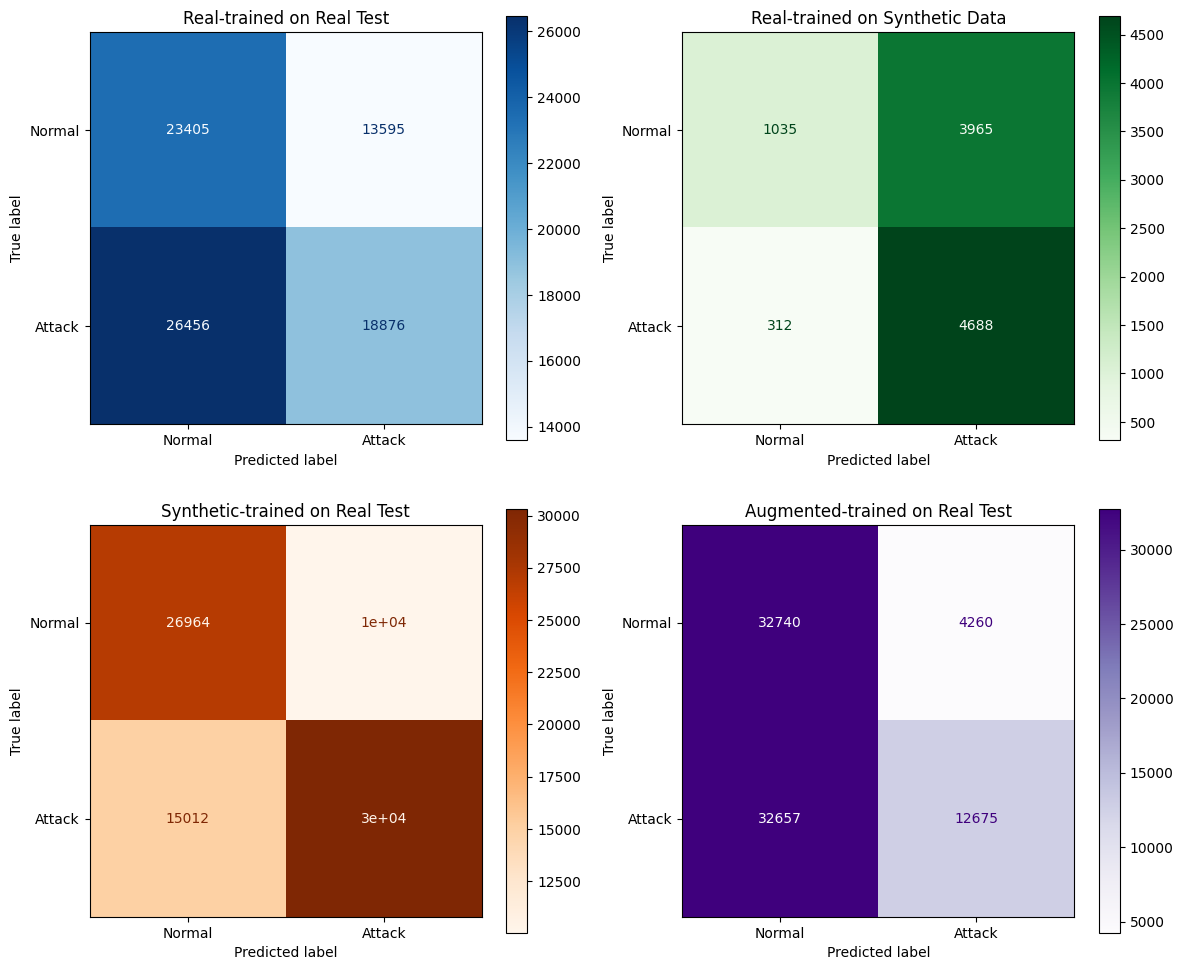

In [8]:
# Plot confusion matrices for each scenario
from sklearn.metrics import ConfusionMatrixDisplay
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=axes[0,0], cmap='Blues', 
    display_labels=['Normal', 'Attack']
)
ConfusionMatrixDisplay.from_predictions(
    y_synth, y_synth_pred_by_real_clf, ax=axes[0,1], cmap='Greens', 
    display_labels=['Normal', 'Attack']
)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_from_synth_trained, ax=axes[1,0], cmap='Oranges', 
    display_labels=['Normal', 'Attack']
)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_aug, ax=axes[1,1], cmap='Purples', 
    display_labels=['Normal', 'Attack']
)
axes[0,0].set_title('Real-trained on Real Test')
axes[0,1].set_title('Real-trained on Synthetic Data')
axes[1,0].set_title('Synthetic-trained on Real Test')
axes[1,1].set_title('Augmented-trained on Real Test')
plt.tight_layout()
plt.show()
